# Gestion de Datos

Para contemplar el universo de probabilidades y compararlo con los resultados optimizados, se ha realizado una simulación de Monte Carlo.

In [95]:
from scipy.stats import kurtosis

n_samples = 10000

In [96]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def plot_sharpe(returns, mask=None):
    # Generamos los pesos aleatoriamente
    n_assets = len(returns.iloc[0])
    mask = np.ones(n_assets) if mask is None else mask

    generator = np.random.default_rng(42)
    weights = generator.random(size=(n_samples, n_assets))
    weights = (mask * weights) / np.sum(weights, axis=1, keepdims=True)

    daily_returns = returns @ weights.T
    daily_returns_std = daily_returns.std(axis=0)
    daily_returns_mean = daily_returns.mean(axis=0)

    plt.scatter(x=daily_returns_std, y=daily_returns_mean, c=daily_returns_mean/daily_returns_std, marker="o", cmap="coolwarm")

    plt.grid(True)
    plt.xlabel("Riesgo (std)")
    plt.ylabel("Retorno esperado")
    plt.title("Retorno vs. Riesgo de carteras aleatorias")
    plt.show()

In [97]:
def get_data(csv=True):
    if csv:
        return pd.read_csv('resources/prod_long_sharpe_u50_20260116_v5_train_dataset.csv')
    else:

        tickers = [
          # --- APALANCADOS (Extrema volatilidad, diseñados para trading diario) ---
          'TQQQ',   # Nasdaq 100 x3 (Mucha volatilidad, alta curtosis)
          'SOXL',   # Semiconductores x3 (Movimientos diarios de +10% son normales)
          'UPRO',   # S&P 500 x3

          # --- CRIPTO & BLOCKCHAIN (Riesgo de cola masivo) ---
          'MSTR',   # MicroStrategy (Actúa como un proxy de Bitcoin con esteroides)
          'MARA',   # Marathon Digital (Minería de Bitcoin, volatilidad extrema)
          'COIN',   # Coinbase

          # --- TECH ESPECULATIVO & GROWTH (Drawdowns profundos) ---
          'TSLA',   # Tesla (El rey de la volatilidad en el S&P 500)
          'PLTR',   # Palantir
          'GME',    # GameStop (El ejemplo perfecto de "Fat Tails" o colas gordas)
        ]

        # Descarga de datos (2 años para tener historial suficiente)
        return yf.download(tickers, period="2y", interval="1d")['Close'].pct_change().dropna()

/tmp/ipython-input-4280427288.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  return yf.download(tickers, period="2y", interval="1d")['Close'].pct_change().dropna()
[*********************100%***********************]  9 of 9 completed


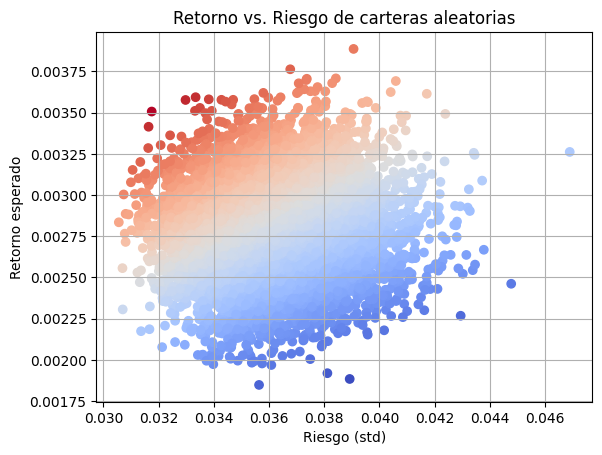

In [98]:

returns = get_data(csv=False)
if not len(returns):
    exit(-1)

plot_sharpe(returns)


Ahora que sabemos que aspecto tiene, vamos a filtrar los activos que tengan una correlación alta, para diversificar la cartera correctamente y reducir la volatilidad (si dos activos con una correlación alta sufren una caída del precio, esto condiciona nuestro ratio de sharpe).
Tambien calculamos la curtosis y eliminamos aquellos que tienen una curtosis muy alta

Mirar asimetrias tambien, queremos una cartera poco volatil y que nos permita maximizar el rendimiento sin sustos

{'PLTR', 'GME', 'TQQQ', 'SOXL', 'UPRO'}
[4, 1, 6, 5, 8]


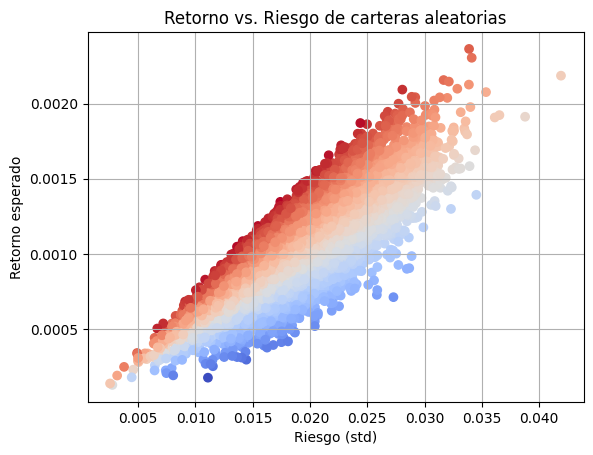

In [99]:
sharpe = returns.mean() / returns.std()

drop = set()

# Curtosis
kurtosis = returns.kurtosis()
for asset, _ in returns.items():
    if (kurtosis[asset] > 6):
        drop.add(asset)

# Obtenemos la correlacion absoluta
correlations = returns.corr().abs()
correlated = correlations[(correlations >= 0.85) & (correlations < 1)].stack()

for (a, b), _ in correlated.items():
    if a in drop or b in drop:
        continue
    if sharpe[a] > sharpe[b]:
        drop.add(b)
    else:
        drop.add(a)


drop_indexes = [returns.columns.get_loc(col) for col in drop]

print(drop)
print(drop_indexes)

mask = np.ones(len(returns.iloc[0]))
mask[drop_indexes] = 0

plot_sharpe(returns, mask)

Lo que usabamos antes:


´´
daily_returns = returns @ weights.T
daily_returns_std = daily_returns.std(axis=0)
daily_returns_mean = daily_returns.mean(axis=0)
Objective -> daily_returns_mean/daily_returns_std

No vale porque no es convexo



In [100]:
import cvxpy as cp

# Los assets con correlacion inferior al 85% y curtosis < 6 y el activo de renta fija
n_assets = len(returns.iloc[0]) + 1

returns_cov = returns.cov()
returns_means = returns.mean(axis=0).values
returns_means = np.append(returns_means, (0.02 / 252)) # 2% se refiere a anual

min_expected_ret_daily = returns_means.min()
max_expected_ret_daily = returns_means.max()

# CVXPY
best_weights = cp.Variable(n_assets)
portfolio_returns = returns_means.T @ best_weights
# La renta fija no afecta a la varianza (riesgo 0)
portfolio_variance = cp.quad_form(best_weights[:-1], returns_cov)

constraints = [
    cp.sum(best_weights) == 1, # Todo el capital debe estar invertido
    best_weights[:-1] <= 1, # Relaxing: Allow up to 100% in each risky asset
    best_weights[-1] <= 1, # Relaxing: Allow up to 100% in risk-free asset
    best_weights >= 0, # No se permiten posiciones cortas
    best_weights[drop_indexes] == 0 # Evitamos dar peso a los activos muy relacionados
]

results = []
rf_daily = 0.2/252
for r_target in np.linspace(min_expected_ret_daily, max_expected_ret_daily, 200):

    r_constraints = constraints + [best_weights @ returns_means >= r_target]

    problem = cp.Problem(cp.Minimize(portfolio_variance), r_constraints)

    problem.solve()

    if best_weights.value is not None:
        ret = portfolio_returns.value
        vol = np.sqrt(portfolio_variance.value)
        sharpe_ratio = (ret - rf_daily) / vol if vol > 0 else 0
        row = np.concatenate([[ret], [vol], [sharpe_ratio], best_weights.value])
        results.append(row)

columns = ["return", "volatility", "sharpe"] + [f"asset{i}" for i in range(n_assets - 1)] + ["Renta Fija"]
portfolio_results = pd.DataFrame(results, columns=columns)
portfolio_results = portfolio_results.sort_values(by="sharpe", ascending=False)
portfolio_results

,return,volatility,sharpe,asset0,asset1,asset2,asset3,asset4,asset5,asset6,asset7,asset8,Renta Fija


In [101]:
# Esta funcion ha sido desarrollada por Gemini 3 en su totalidad, se ha limpiado para adaptarla a
def round_weights(weights, decimals=3):

    rounded_weights = np.floor(np.array(weights) * (10**decimals)) / (10**decimals)
    rounded_weights[rounded_weights < 0] = 0
    diff = round(1.0 - np.sum(rounded_weights), decimals)
    priority_idxs = np.argsort(weights)[::-1]
    step = 1 / (10**decimals)

    i = 0
    while diff > 0:
        i += 1
        diff = round(diff - step, decimals)
        idx = priority_idxs[i % len(priority_idxs)]
        rounded_weights[idx] = round(rounded_weights[idx] + step, decimals)

    return rounded_weights

In [102]:
rounded_weights = round_weights(portfolio_results.iloc[0, 3:].tolist())
pesos_limpios = [f"{p:g}" for p in rounded_weights]
print(pesos_limpios)

IndexError: single positional indexer is out-of-bounds

In [ ]:
# Sortino (Gemini 3)

# 1. Calculamos el retorno diario histórico de la cartera
portfolio_daily_returns = returns.values @ np.array(rounded_weights[:-1])

# 2. Definimos el umbral (Tasa libre de riesgo diaria)
rf_diaria = 0.000079

# 3. Filtramos solo los retornos que fueron menores que la RF
excess_returns = portfolio_daily_returns - rf_diaria
downside_diff = excess_returns[excess_returns < 0]

# 4. Calculamos la volatilidad a la baja
downside_deviation = np.sqrt(np.mean(downside_diff**2))
print("Downside Deviation:", downside_deviation)